In [1]:
import dgl
import networkx as nx
import torch as th

![image](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png)

In [2]:
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

In [3]:
dataset = MiniGCDataset(80,10,20)
graph,label = dataset[0]

In [23]:
for data in dataset:
#     print(data)
    print('graph: ',data[0].number_of_nodes(),'edge: ',data[0].number_of_edges(),
         'class: ',data[1])

graph:  18 edge:  54 class:  0
graph:  19 edge:  57 class:  0
graph:  10 edge:  30 class:  0
graph:  18 edge:  54 class:  0
graph:  11 edge:  33 class:  0
graph:  10 edge:  30 class:  0
graph:  16 edge:  48 class:  0
graph:  14 edge:  42 class:  0
graph:  10 edge:  30 class:  0
graph:  11 edge:  33 class:  0
graph:  10 edge:  28 class:  1
graph:  12 edge:  34 class:  1
graph:  12 edge:  34 class:  1
graph:  15 edge:  43 class:  1
graph:  13 edge:  37 class:  1
graph:  18 edge:  52 class:  1
graph:  17 edge:  49 class:  1
graph:  13 edge:  37 class:  1
graph:  11 edge:  31 class:  1
graph:  13 edge:  37 class:  1
graph:  11 edge:  51 class:  2
graph:  16 edge:  76 class:  2
graph:  18 edge:  86 class:  2
graph:  10 edge:  46 class:  2
graph:  17 edge:  81 class:  2
graph:  10 edge:  46 class:  2
graph:  15 edge:  71 class:  2
graph:  15 edge:  71 class:  2
graph:  19 edge:  91 class:  2
graph:  15 edge:  71 class:  2
graph:  13 edge:  127 class:  3
graph:  12 edge:  90 class:  3
graph: 

In [21]:
# graph.number_of_nodes(),graph.number_of_edges()

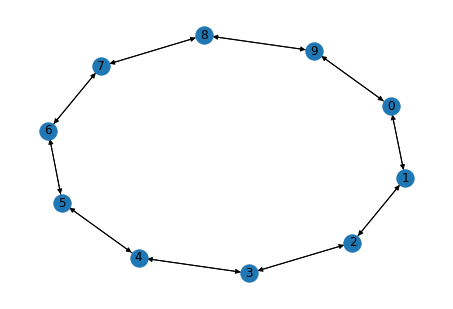

In [16]:
nx.draw(graph1.to_networkx(),with_labels=True)

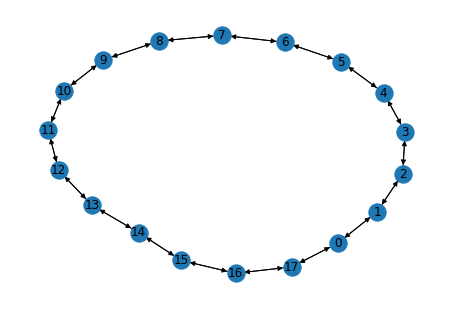

In [50]:
nx.draw(graph.to_networkx(),with_labels=True)

In [51]:
import dgl
import pandas as pd
import numpy as np

In [33]:
# let data with tuple format to list
data = [(0,1),(2,3),(4,5),(6,7)]

In [48]:
a,b = map(list,zip(*data))

In [49]:
def pri(*dat):
    print(list(zip(*dat)))

In [92]:
def collate(samples):
    graphs,labels = map(list,zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph,torch.tensor(labels)

![graph classification](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png)

$$\begin{eqnarray*} h_{v}^{(l+1)} &=& \text{ReLU}\left(b^{(l)}+\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right) \\ h_{v}^{(l+1)} &=& \text{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|}\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)\end{eqnarray*}$$

- linear activation after message passing

In [93]:
import dgl.function as fn
import torch.nn as nn
import torch

In [94]:
msg = fn.copy_src(src='h',out='m')
def reduce(nodes):
    return {'h' : torch.mean(nodes.mailbox['m'] ,1)}

In [142]:
class NodeApplyModule(nn.Module):
    def __init__(self,in_feats,out_feats,activation):
        super(NodeApplyModule,self).__init__()
        self.linear = nn.Linear(in_feats,out_feats)
        self.activation = activation
    def forward(self,nodes):
        h = self.linear(nodes.data['h'])
        h = self.activation(h)
        return {'h' : h}

In [143]:
class GCN(nn.Module):
    def __init__(self,in_feats,out_feats,activation):
        super(GCN,self).__init__()
        self.apply_mod = NodeApplyModule(in_feats,out_feats,activation)
    def forward(self,g,feature):
        g.ndata['h'] = feature
        g.update_all(msg,reduce_func = reduce)
        g.apply_nodes(func = self.apply_mod)
        return g.ndata.pop('h')

$h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}$

In [138]:
import torch.nn.functional as F

In [144]:
class Classifier(nn.Module):
    def __init__(self,in_dim,hidden_dim,n_class):
        super(Classifier,self).__init__()
        self.layers = nn.ModuleList([
            GCN(in_feats=in_dim,out_feats=hidden_dim,activation=F.relu),
            GCN(in_feats=hidden_dim,out_feats=hidden_dim,activation=F.relu)
        ])
        self.classifier = nn.Linear(hidden_dim,n_class)
    def forward(self,g):
        h = g.in_degrees().view(-1,1).float()
        for conv in self.layers:
            h = conv(g,h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g,'h')
        return self.classifier(hg)

In [145]:
from torch.utils.data import DataLoader
import torch.optim as optim
trainset = MiniGCDataset(320,10,20)
testset = MiniGCDataset(80,10,20)

In [146]:
data_loader = DataLoader(trainset,batch_size = 32,shuffle = True,collate_fn=collate)
model = Classifier(1,256,trainset.num_classes)
print(graph.number_of_nodes(),graph.number_of_edges())
out = model(graph)

415 2611


In [147]:

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
epoch_losses = []
for epoch in range(80):
    epoch_loss = 0
    for i,(graph,label) in enumerate(data_loader):
        prediction = model(graph)
        loss = loss_func(prediction,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= (i + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch,epoch_loss))


/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


Epoch 0, loss 2.0983
Epoch 1, loss 1.9620
Epoch 2, loss 1.9063
Epoch 3, loss 1.8177
Epoch 4, loss 1.7598
Epoch 5, loss 1.7227
Epoch 6, loss 1.5857
Epoch 7, loss 1.5129
Epoch 8, loss 1.4308
Epoch 9, loss 1.3750
Epoch 10, loss 1.3205
Epoch 11, loss 1.2655
Epoch 12, loss 1.1970
Epoch 13, loss 1.1615
Epoch 14, loss 1.1197
Epoch 15, loss 1.0685
Epoch 16, loss 1.0442
Epoch 17, loss 1.0380
Epoch 18, loss 1.0099
Epoch 19, loss 0.9626
Epoch 20, loss 0.9485
Epoch 21, loss 0.9328
Epoch 22, loss 0.9068
Epoch 23, loss 0.8969
Epoch 24, loss 0.8787
Epoch 25, loss 0.8608
Epoch 26, loss 0.8650
Epoch 27, loss 0.8170
Epoch 28, loss 0.8223
Epoch 29, loss 0.8028
Epoch 30, loss 0.7810
Epoch 31, loss 0.7843
Epoch 32, loss 0.7949
Epoch 33, loss 0.7929
Epoch 34, loss 0.7683
Epoch 35, loss 0.7412
Epoch 36, loss 0.7748
Epoch 37, loss 0.7959
Epoch 38, loss 0.7513
Epoch 39, loss 0.7472
Epoch 40, loss 0.7186
Epoch 41, loss 0.6974
Epoch 42, loss 0.7152
Epoch 43, loss 0.6826
Epoch 44, loss 0.6809
Epoch 45, loss 0.660

In [102]:
arr = torch.Tensor([[1,2,3],[4,5,6]])

In [108]:
torch.softmax(arr,1)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [115]:
test_X, test_Y = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

Accuracy of sampled predictions on the test set: 75.0000%
Accuracy of argmax predictions on the test set: 81.250000%


/Users/icdi/Desktop/py_ws/venv/lib/python3.5/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/test_eval4.gif)

t-SNE for visualization, <https://lvdmaaten.github.io/tsne/>